In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aklimarimi/8-facial-expressions-for-yolo")

print("Path to dataset files:", path)

Using Colab cache for faster access to the '8-facial-expressions-for-yolo' dataset.
Path to dataset files: /kaggle/input/8-facial-expressions-for-yolo


In [ ]:
# @title Skrip Cropping Biner (OPTIMIZED)
import os, cv2, shutil, glob
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import multiprocessing as mp

# --- Konfigurasi ---
DATA_DIR = path
CROPPED_FACES_DIR = 'binary_sleepy_data'
# Urutan asli: ['angry', 'contempt', 'disgust', 'fear', 'happy', 'natural', 'sad', 'sleepy', 'surprised']
# Indeks 7 adalah 'sleepy'
SLEEPY_INDEX = 7

def process_label_file_binary(label_file_path):
    label_dir = os.path.dirname(label_file_path)
    file_name = os.path.basename(label_file_path)
    image_name_base = os.path.splitext(file_name)[0]

    image_dir = os.path.join(os.path.dirname(label_dir), 'images')
    image_path = None
    for ext in ['.jpg', '.jpeg', '.png', '.JPG']:
        tmp = os.path.join(image_dir, image_name_base + ext)
        if os.path.exists(tmp):
            image_path = tmp
            break

    if not image_path: return 0
    img = cv2.imread(image_path)
    if img is None: return 0
    H, W, _ = img.shape
    count = 0

    try:
        with open(label_file_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) != 5: continue

                class_id = int(parts[0])
                # LOGIKA BINARY: Jika ID 7 maka 'sleepy', selain itu 'non_sleepy'
                label_name = 'sleepy' if class_id == SLEEPY_INDEX else 'non_sleepy'

                x_c, y_c, w, h = [float(p) for p in parts[1:]]
                x_min = max(0, int((x_c - w/2) * W) - 10)
                y_min = max(0, int((y_c - h/2) * H) - 10)
                x_max = min(W, int((x_c + w/2) * W) + 10)
                y_max = min(H, int((y_c + h/2) * H) + 10)

                face = img[y_min:y_max, x_min:x_max]
                if face.size == 0: continue

                # Simpan sementara di folder temp
                temp_save_path = os.path.join(CROPPED_FACES_DIR, 'temp', label_name, f"{image_name_base}_{count}.jpg")
                cv2.imwrite(temp_save_path, face)
                count += 1
    except: pass
    return count

# Setup Struktur Folder
if os.path.exists(CROPPED_FACES_DIR): shutil.rmtree(CROPPED_FACES_DIR)
for split in ['train', 'val', 'temp']:
    for cls in ['sleepy', 'non_sleepy']:
        os.makedirs(os.path.join(CROPPED_FACES_DIR, split, cls), exist_ok=True)

# Eksekusi Parallel
label_files = []
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if f.endswith('.txt'): label_files.append(os.path.join(root, f))

print(f"Memproses {len(label_files)} file label...")
with mp.Pool(mp.cpu_count()) as pool:
    results = list(tqdm(pool.imap_unordered(process_label_file_binary, label_files), total=len(label_files)))

# Split Data 80/20
all_paths, all_labels = [], []
for cls in ['sleepy', 'non_sleepy']: # Perbaikan typo folder jika ada
    path_cls = os.path.join(CROPPED_FACES_DIR, 'temp', cls)
    if os.path.exists(path_cls):
        for img in os.listdir(path_cls):
            all_paths.append(os.path.join(path_cls, img))
            all_labels.append(cls)

train_p, val_p, _, _ = train_test_split(all_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

def move_files(paths, split):
    for p in paths:
        cls = os.path.basename(os.path.dirname(p))
        dest = os.path.join(CROPPED_FACES_DIR, split, cls, os.path.basename(p))
        shutil.move(p, dest)

move_files(train_p, 'train')
move_files(val_p, 'val')
shutil.rmtree(os.path.join(CROPPED_FACES_DIR, 'temp'))
print(f"\n✅ Berhasil! Train: {len(train_p)}, Val: {len(val_p)}")

Memproses 68286 file label...


100%|██████████| 68286/68286 [08:16<00:00, 137.49it/s]



✅ Berhasil! Train: 54627, Val: 13657


In [ ]:
# @title Skrip Data Loaders & Model Init
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

# Transformasi: Tip 3 (Augmentasi fokus pada fitur wajah)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Fokus area mata/mulut
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(CROPPED_FACES_DIR, x), data_transforms[x]) for x in ['train', 'val']}

# --- HANDLING IMBALANCE (Tip 1) ---
train_labels = np.array(image_datasets['train'].targets)
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, sampler=sampler, num_workers=2),
    'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

# Inisialisasi Model untuk 2 Kelas
model_ft = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(DEVICE)

print(f"Kelas terdeteksi: {image_datasets['train'].classes}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 108MB/s] 


Kelas terdeteksi: ['non_sleepy', 'sleepy']


In [ ]:
# @title Skrip Training Loop (dengan Early Stopping)
import time
import copy
import torch.optim as optim
from tqdm.auto import tqdm

# --- Konfigurasi ---
NUM_EPOCHS = 10  # Anda bisa menaikkan ini karena ada Early Stopping
PATIENCE = 3     # Jika loss validasi tidak turun selama 3 epoch, training berhenti
MODEL_SAVE_NAME = 'best_efficientnet_sleepy.pth'

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.001, weight_decay=1e-4)
exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=NUM_EPOCHS)

def train_with_early_stopping(model, criterion, optimizer, scheduler, num_epochs, patience):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')
    early_stop_counter = 0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 15)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0

            pbar = tqdm(dataloaders[phase], desc=f"{phase.upper()}", leave=False)
            for inputs, labels in pbar:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # Cek Peningkatan untuk Early Stopping
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    # Simpan ke file lokal agar bisa didownload nanti
                    torch.save(best_model_wts, MODEL_SAVE_NAME)
                    early_stop_counter = 0
                    print("✅ Peningkatan terdeteksi, model disimpan.")
                else:
                    early_stop_counter += 1
                    print(f"⚠️ Tidak ada peningkatan. Counter: {early_stop_counter}/{patience}")

            else:
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())

        scheduler.step()

        # Eksekusi Early Stopping
        if early_stop_counter >= patience:
            print(f"\n🛑 Early Stopping dipicu! Berhenti di epoch {epoch+1}")
            break

    time_elapsed = time.time() - since
    print(f'\nTraining selesai dalam {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Akurasi Val Terbaik: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# Mulai Training
model_ft, training_history = train_with_early_stopping(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS, patience=PATIENCE
)


Epoch 1/10
---------------


TRAIN:   0%|          | 0/1708 [00:00<?, ?it/s]

Train Loss: 0.0530 Acc: 0.9827


VAL:   0%|          | 0/427 [00:00<?, ?it/s]

Val Loss: 0.0376 Acc: 0.9894
✅ Peningkatan terdeteksi, model disimpan.

Epoch 2/10
---------------


TRAIN:   0%|          | 0/1708 [00:00<?, ?it/s]

Train Loss: 0.0243 Acc: 0.9925


VAL:   0%|          | 0/427 [00:00<?, ?it/s]

Val Loss: 0.0364 Acc: 0.9902
✅ Peningkatan terdeteksi, model disimpan.

Epoch 3/10
---------------


TRAIN:   0%|          | 0/1708 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a0183f37100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a0183f37100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0173 Acc: 0.9945


VAL:   0%|          | 0/427 [00:00<?, ?it/s]

Val Loss: 0.0428 Acc: 0.9868
⚠️ Tidak ada peningkatan. Counter: 1/3

Epoch 4/10
---------------


TRAIN:   0%|          | 0/1708 [00:00<?, ?it/s]

Train Loss: 0.0103 Acc: 0.9967


VAL:   0%|          | 0/427 [00:00<?, ?it/s]

Val Loss: 0.0616 Acc: 0.9812
⚠️ Tidak ada peningkatan. Counter: 2/3

Epoch 5/10
---------------


TRAIN:   0%|          | 0/1708 [00:00<?, ?it/s]

Train Loss: 0.0102 Acc: 0.9969


VAL:   0%|          | 0/427 [00:00<?, ?it/s]

Val Loss: 0.0334 Acc: 0.9895
✅ Peningkatan terdeteksi, model disimpan.

Epoch 6/10
---------------


TRAIN:   0%|          | 0/1708 [00:00<?, ?it/s]

Train Loss: 0.0055 Acc: 0.9984


VAL:   0%|          | 0/427 [00:00<?, ?it/s]

Val Loss: 0.0410 Acc: 0.9878
⚠️ Tidak ada peningkatan. Counter: 1/3

Epoch 7/10
---------------


TRAIN:   0%|          | 0/1708 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a0183f37100>Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a0183f37100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.0041 Acc: 0.9988


VAL:   0%|          | 0/427 [00:00<?, ?it/s]

Val Loss: 0.0318 Acc: 0.9922
✅ Peningkatan terdeteksi, model disimpan.

Epoch 8/10
---------------


TRAIN:   0%|          | 0/1708 [00:00<?, ?it/s]

Train Loss: 0.0028 Acc: 0.9991


VAL:   0%|          | 0/427 [00:00<?, ?it/s]

Val Loss: 0.0140 Acc: 0.9963
✅ Peningkatan terdeteksi, model disimpan.

Epoch 9/10
---------------


TRAIN:   0%|          | 0/1708 [00:00<?, ?it/s]

Train Loss: 0.0014 Acc: 0.9997


VAL:   0%|          | 0/427 [00:00<?, ?it/s]

Val Loss: 0.0137 Acc: 0.9964
✅ Peningkatan terdeteksi, model disimpan.

Epoch 10/10
---------------


TRAIN:   0%|          | 0/1708 [00:00<?, ?it/s]

Train Loss: 0.0006 Acc: 0.9998


VAL:   0%|          | 0/427 [00:00<?, ?it/s]

Val Loss: 0.0143 Acc: 0.9962
⚠️ Tidak ada peningkatan. Counter: 1/3

Training selesai dalam 74m 6s
Akurasi Val Terbaik: 0.996412


Evaluating:   0%|          | 0/427 [00:00<?, ?it/s]


CLASSIFICATION REPORT
              precision    recall  f1-score   support

  non_sleepy       1.00      1.00      1.00     13433
      sleepy       0.85      0.96      0.90       224

    accuracy                           1.00     13657
   macro avg       0.92      0.98      0.95     13657
weighted avg       1.00      1.00      1.00     13657



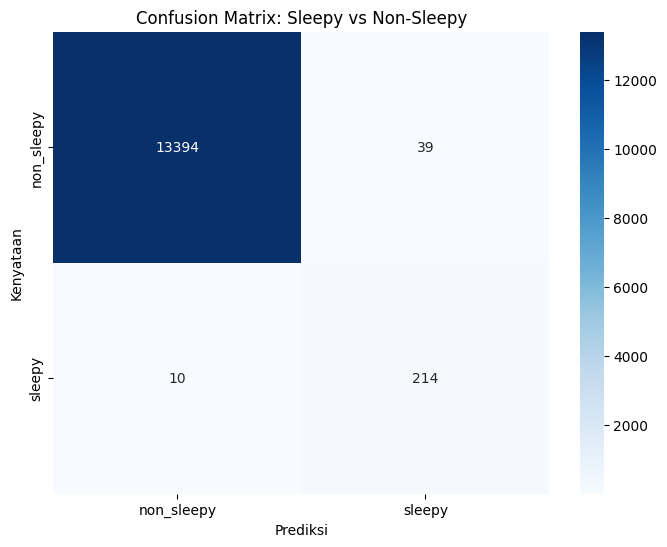

In [ ]:
# @title Skrip Evaluasi Lengkap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def run_evaluation(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 1. Classification Report
    print("\n" + "="*30)
    print("CLASSIFICATION REPORT")
    print("="*30)
    print(classification_report(all_labels, all_preds, target_names=dataloader.dataset.classes))

    # 2. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataloader.dataset.classes,
                yticklabels=dataloader.dataset.classes)
    plt.title('Confusion Matrix: Sleepy vs Non-Sleepy')
    plt.xlabel('Prediksi')
    plt.ylabel('Kenyataan')
    plt.show()

# Jalankan evaluasi pada data val
run_evaluation(model_ft, dataloaders['val'])

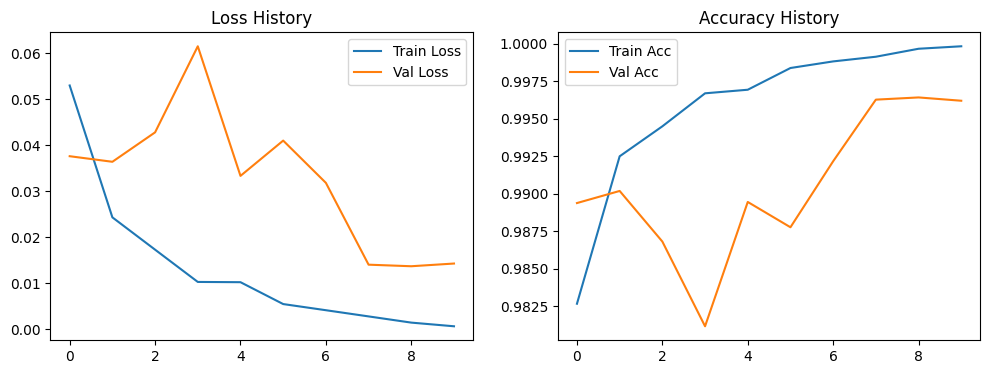

In [ ]:
# @title Visualisasi History Training
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(training_history['train_loss'], label='Train Loss')
plt.plot(training_history['val_loss'], label='Val Loss')
plt.title('Loss History')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(training_history['train_acc'], label='Train Acc')
plt.plot(training_history['val_acc'], label='Val Acc')
plt.title('Accuracy History')
plt.legend()

plt.show()

In [ ]:
# @title Download Bobot Model Terbaik
from google.colab import files
import os

if os.path.exists(MODEL_SAVE_NAME):
    print(f"Mengunduh {MODEL_SAVE_NAME}...")
    files.download(MODEL_SAVE_NAME)
else:
    print("❌ File model tidak ditemukan. Pastikan training sudah berjalan.")

Mengunduh best_efficientnet_sleepy.pth...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>